In [25]:
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [26]:
# -------------------------------
# Step 1: Load and Clean WHQ_df (with BMI Calculation)
# -------------------------------
WHQ_df = pd.read_csv('WHQ_L.csv')

# Replace the placeholder values (7777, 9999, and blanks) with NaN
WHQ_df.replace({7777: np.nan, 9999: np.nan}, inplace=True)
WHQ_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
WHQ_df.dropna(inplace=True)

# Calculate BMI using the formula: BMI = (weight in lbs / (height in inches)^2) * 703
WHQ_df['BMI'] = (WHQ_df['WHD020'] / (WHQ_df['WHD010'] ** 2)) * 703

# Define a function to classify BMI
def classify_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Healthy Weight'
    elif bmi < 30:
        return 'Overweight'
    elif bmi < 35:
        return 'Class 1 Obesity'
    elif bmi < 40:
        return 'Class 2 Obesity'
    else:
        return 'Class 3 Obesity'

# Apply the classification to create a new column
WHQ_df['BMI_category'] = WHQ_df['BMI'].apply(classify_bmi)

WHQ_df.drop(['WHD010', 'WHD020', 'WHD050' ,'WHQ070', 'BMI' ], axis=1, inplace=True)

print("First few rows of cleaned WHQ_df:")
print(WHQ_df.head())

First few rows of cleaned WHQ_df:
       SEQN     BMI_category
0  130378.0       Overweight
1  130379.0  Class 1 Obesity
2  130380.0       Overweight
3  130384.0  Class 1 Obesity
4  130385.0  Class 1 Obesity


In [27]:
# -------------------------------
# Step 2: Load the Other DataFrames
# -------------------------------
ALQ_df    = pd.read_csv('ALQ_L.csv')
BAX_df    = pd.read_csv('BAX_L.csv')
#BMX_df    = pd.read_csv('BMX_L.csv')
BPQ_df    = pd.read_csv('BPQ_L.csv')
BPXO_df   = pd.read_csv('BPXO_L.csv')
DBQ_df    = pd.read_csv('DBQ_L.csv')
DEMO_df   = pd.read_csv('DEMO_L.csv')
DR1IFF_df = pd.read_csv('DR1IFF_L.csv')
MCQ_df    = pd.read_csv('MCQ_L.csv')
PAQ_df    = pd.read_csv('PAQ_L.csv')
# Note: WHQ_df is already loaded and processed above.

In [28]:
# -------------------------------
# Step 3: Merge All DataFrames on 'SEQN'
# -------------------------------
dfs = [ALQ_df, BAX_df, BPQ_df, BPXO_df, DBQ_df, DEMO_df, DR1IFF_df, MCQ_df, PAQ_df, WHQ_df]
merged_df = reduce(lambda left, right: pd.merge(left, right, on='SEQN', how='outer'), dfs)

print("Columns in merged_df:")
print(merged_df.columns)

Columns in merged_df:
Index(['SEQN', 'ALQ111', 'ALQ121', 'ALQ130', 'ALQ142', 'ALQ270', 'ALQ280',
       'ALQ151', 'ALQ170', 'BAXMSTAT',
       ...
       'MCQ230D', 'OSQ230', 'PAD790Q', 'PAD790U', 'PAD800', 'PAD810Q',
       'PAD810U', 'PAD820', 'PAD680', 'BMI_category'],
      dtype='object', length=246)


In [43]:
# -------------------------------
# Step 4: Clean Merged Data
# -------------------------------
# Drop rows missing the target 'BMI_category'
merged_df.dropna(subset=['BMI_category'], inplace=True)
merged_df.replace({7777: np.nan, 9999: np.nan}, inplace=True)
# Fill missing values with 0 for all remaining columns
merged_df.fillna(0, inplace=True)
df = merged_df


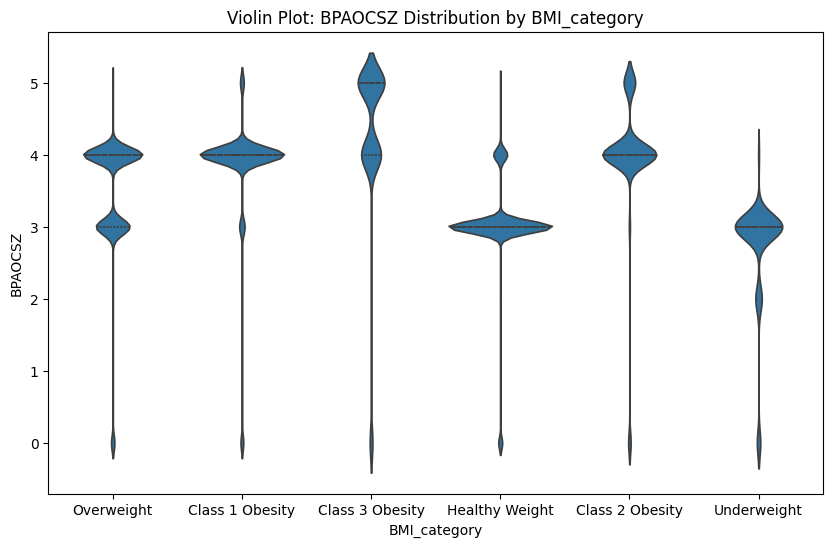

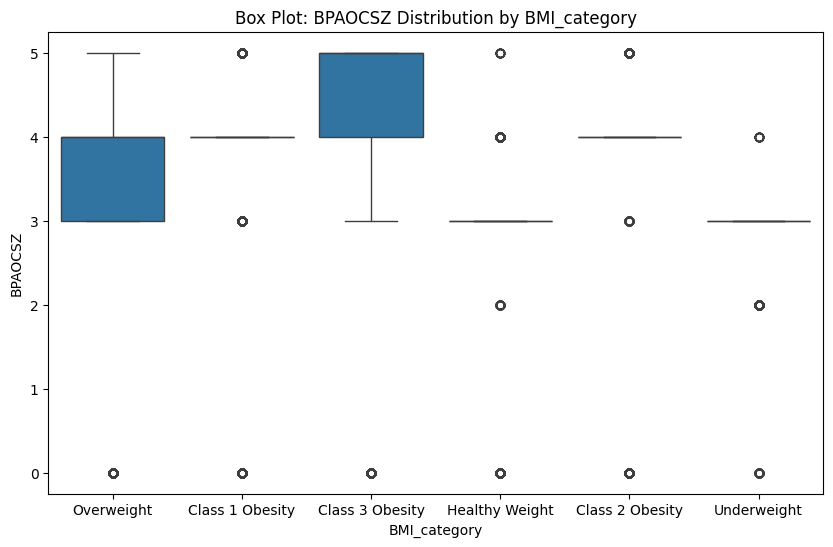

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(x='BMI_category', y='BPAOCSZ', data=merged_df, inner='quartile')
plt.title('Violin Plot: BPAOCSZ Distribution by BMI_category')
plt.xlabel('BMI_category')
plt.ylabel('BPAOCSZ')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='BMI_category', y='BPAOCSZ', data=merged_df)
plt.title('Box Plot: BPAOCSZ Distribution by BMI_category')
plt.xlabel('BMI_category')
plt.ylabel('BPAOCSZ')
plt.show()


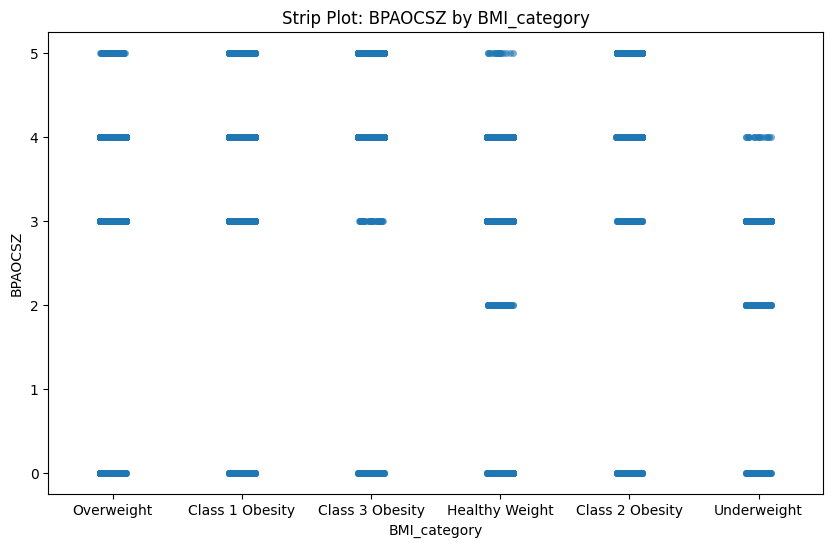

In [45]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='BMI_category', y='BPAOCSZ', data=merged_df, jitter=True, alpha=0.6)
plt.title('Strip Plot: BPAOCSZ by BMI_category')
plt.xlabel('BMI_category')
plt.ylabel('BPAOCSZ')
plt.show()


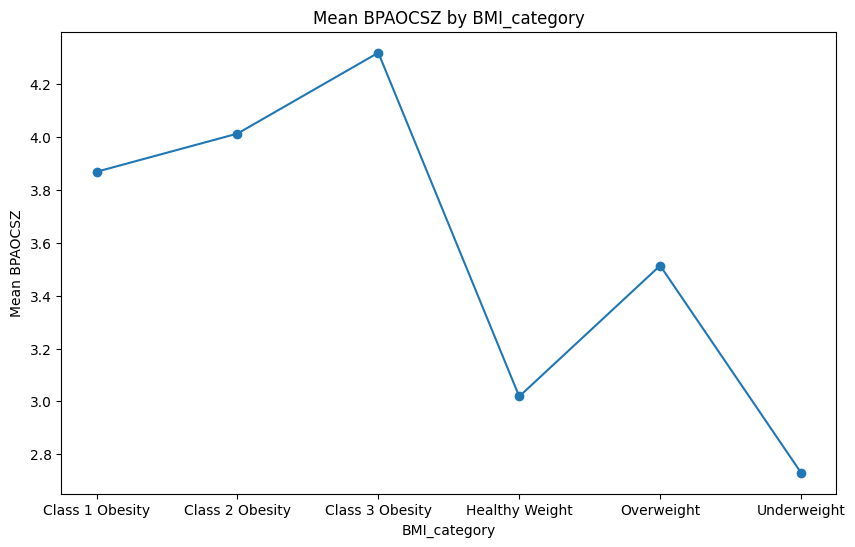

In [46]:
import pandas as pd

# Compute the mean BPAOCSZ for each BMI_category
means = merged_df.groupby('BMI_category')['BPAOCSZ'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(means['BMI_category'], means['BPAOCSZ'], marker='o', linestyle='-')
plt.title('Mean BPAOCSZ by BMI_category')
plt.xlabel('BMI_category')
plt.ylabel('Mean BPAOCSZ')
plt.show()


In [47]:
import numpy as np
import pandas as pd

def correlation_ratio(categories, measurements):
    """
    Compute the correlation ratio (eta squared) for a numeric variable (measurements)
    and a categorical variable (categories).
    """
    categories = np.array(categories)
    measurements = np.array(measurements)
    # Factorize categories to get numeric labels
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    overall_mean = np.mean(measurements)
    
    # Between-group sum of squares
    ss_between = 0
    for i in range(cat_num):
        cat_measurements = measurements[fcat == i]
        cat_mean = np.mean(cat_measurements)
        ss_between += len(cat_measurements) * (cat_mean - overall_mean) ** 2
    
    # Total sum of squares
    ss_total = np.sum((measurements - overall_mean) ** 2)
    eta_squared = ss_between / ss_total if ss_total != 0 else 0
    return eta_squared

# Compute eta squared for BPAOCSZ vs. BMI_category
eta2 = correlation_ratio(merged_df['BMI_category'], merged_df['BPAOCSZ'])
print("Correlation Ratio (η²):", eta2)


Correlation Ratio (η²): 0.22242877951042223


In [48]:
from scipy.stats import f_oneway

# Group BPAOCSZ values by BMI_category
groups = [group['BPAOCSZ'].dropna().values for name, group in merged_df.groupby('BMI_category')]
f_stat, p_value = f_oneway(*groups)
print("ANOVA F-statistic:", f_stat)
print("ANOVA p-value:", p_value)


ANOVA F-statistic: 4557.727511710373
ANOVA p-value: 0.0


In [49]:
from sklearn.feature_selection import mutual_info_classif

# Prepare data for mutual information calculation
X = merged_df[['BPAOCSZ']].values  # Feature matrix
y = merged_df['BMI_category'].values  # Target variable

# Compute mutual information (set discrete_features=False since BPAOCSZ is continuous)
mi = mutual_info_classif(X, y, discrete_features=False)
print("Mutual Information for BPAOCSZ:", mi[0])


Mutual Information for BPAOCSZ: 0.3595366947482921


In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# ----- Optional Scaling -----
# Set this flag to True if you want to scale your features before plotting.
scale_data = False  # Change to True to scale

# Make a copy of your DataFrame to work with scaled data if needed.
if scale_data:
    scaler = StandardScaler()
    df_scaled = df.copy()
    # Get numeric columns excluding the target
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'BMI_category' in numeric_features:
        numeric_features.remove('BMI_category')
    df_scaled[numeric_features] = scaler.fit_transform(df_scaled[numeric_features])
else:
    df_scaled = df.copy()

# ----- Folder Setup -----
main_plot_dir = "plots"
plot_types = ['violin', 'box', 'strip', 'mean_trend']

# Create main directory if it doesn't exist
if not os.path.exists(main_plot_dir):
    os.makedirs(main_plot_dir)

# Create subdirectories for each plot type
for plot_type in plot_types:
    subfolder = os.path.join(main_plot_dir, plot_type)
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)

target = 'BMI_category'

# ----- Plotting Loop -----
for feature in df_scaled.columns:
    if feature == target:
        continue
    # Process only numeric features
    if np.issubdtype(df_scaled[feature].dtype, np.number):
        # 1. Violin Plot
        plt.figure(figsize=(10, 6))
        sns.violinplot(x=target, y=feature, data=df_scaled, inner='quartile')
        plt.title(f'Violin Plot: {feature} by {target}')
        plt.xlabel(target)
        plt.ylabel(feature)
        plt.tight_layout()
        plt.savefig(os.path.join(main_plot_dir, 'violin', f"{feature}_violin.png"))
        plt.close()

        # 2. Box Plot
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=target, y=feature, data=df_scaled)
        plt.title(f'Box Plot: {feature} by {target}')
        plt.xlabel(target)
        plt.ylabel(feature)
        plt.tight_layout()
        plt.savefig(os.path.join(main_plot_dir, 'box', f"{feature}_box.png"))
        plt.close()

        # 3. Strip Plot
        plt.figure(figsize=(10, 6))
        sns.stripplot(x=target, y=feature, data=df_scaled, jitter=True, alpha=0.6)
        plt.title(f'Strip Plot: {feature} by {target}')
        plt.xlabel(target)
        plt.ylabel(feature)
        plt.tight_layout()
        plt.savefig(os.path.join(main_plot_dir, 'strip', f"{feature}_strip.png"))
        plt.close()

        # 4. Mean Trend Plot
        # Compute the mean of the feature per target category
        means = df_scaled.groupby(target)[feature].mean().reset_index()
        plt.figure(figsize=(10, 6))
        plt.plot(means[target], means[feature], marker='o', linestyle='-')
        plt.title(f'Mean Trend Plot: {feature} by {target}')
        plt.xlabel(target)
        plt.ylabel(f'Mean {feature}')
        plt.tight_layout()
        plt.savefig(os.path.join(main_plot_dir, 'mean_trend', f"{feature}_mean_trend.png"))
        plt.close()

print("All plots have been saved in their respective folders within the 'plots' directory.")


All plots have been saved in their respective folders within the 'plots' directory.


In [51]:
import numpy as np
import pandas as pd
from scipy.stats import f_oneway
from sklearn.feature_selection import mutual_info_classif

# Function to compute the correlation ratio (eta squared)
def correlation_ratio(categories, measurements):
    """
    Compute the correlation ratio (η²) for a numeric variable (measurements)
    and a categorical variable (categories).
    """
    categories = np.array(categories)
    measurements = np.array(measurements)
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    overall_mean = np.mean(measurements)
    
    ss_between = 0
    for i in range(cat_num):
        cat_measurements = measurements[fcat == i]
        cat_mean = np.mean(cat_measurements)
        ss_between += len(cat_measurements) * (cat_mean - overall_mean) ** 2
    
    ss_total = np.sum((measurements - overall_mean) ** 2)
    eta_squared = ss_between / ss_total if ss_total != 0 else 0
    return eta_squared

# Prepare target variable
target = 'BMI_category'
y = df[target].values

# List to store results for each feature
results = []

# Loop through each column in the DataFrame (skipping the target)
for feature in df.columns:
    if feature == target:
        continue
    
    # Check if the feature is numeric
    is_numeric = np.issubdtype(df[feature].dtype, np.number)
    
    if is_numeric:
        # Compute correlation ratio (η²)
        eta2 = correlation_ratio(df[target], df[feature])
        
        # Compute ANOVA F-test:
        groups = [group[feature].dropna().values for _, group in df.groupby(target)]
        try:
            f_stat, p_value = f_oneway(*groups)
        except Exception as e:
            f_stat, p_value = np.nan, np.nan
        
        # Compute Mutual Information
        mi = mutual_info_classif(df[[feature]].values, y, discrete_features=False)
        mi_val = mi[0]
    else:
        # For non-numeric features, you might need a different approach.
        # Here, we leave the values as None (or you could convert them to categorical codes).
        eta2 = None
        f_stat, p_value = None, None
        mi_val = None
    
    results.append({
        'feature': feature,
        'correlation_ratio': eta2,
        'anova_F': f_stat,
        'anova_p': p_value,
        'mutual_info': mi_val
    })

# Convert the results to a DataFrame and sort by correlation ratio (or any other metric you prefer)
results_df = pd.DataFrame(results)
results_df.sort_values(by='correlation_ratio', ascending=False, inplace=True)

# Save the results to a CSV file
results_df.to_csv("feature_selection_metrics.csv", index=False)
print("Saved feature selection metrics to 'feature_selection_metrics.csv'")
results_df.head()


C:\Users\Wen Jun\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\Wen Jun\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\Wen Jun\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\Wen Jun\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats

Saved feature selection metrics to 'feature_selection_metrics.csv'


,feature,correlation_ratio,anova_F,anova_p,mutual_info
59,BPAOCSZ,0.222429,4557.727512,0.0,0.359850
9,BAXMSTAT,0.063088,1072.865066,0.0,0.031677
53,BPQ020,0.049777,834.637778,0.0,0.030536
55,BPQ150,0.042632,709.505582,0.0,0.030098
112,DMDHRAGZ,0.037783,625.628325,0.0,0.017658
